Original noise parameters ($\sigma_\Omega, \sigma_\Delta, \sigma_\epsilon$) based on "Experimental Bayesian Calibration of Trapped-Ion Entangling Operations" (https://journals.aps.org/prxquantum/abstract/10.1103/PRXQuantum.3.020350).

Derivative noise parameters ($\sigma_I, \sigma_{f_{cl}}, \sigma_{f_{sb}}$) based on **single_qubit_rotations/single_qubit_noise_sim.ipynb**.

In [1]:
# Run this cell to test if the LinearChain object is gonna give us a headache.
using IonSim

@time chain = LinearChain(
        ions=[Ca40([("S1/2", -1/2, "S"), ("D5/2", -1/2, "D")]), Ca40([("S1/2", -1/2, "S"), ("D5/2", -1/2, "D")])], 
        comfrequencies=(x=3e6,y=3e6,z=2.5e5), selectedmodes=(;z=[1],)
    )
chain = Nothing;

  8.263539 seconds (14.82 M allocations: 953.521 MiB, 6.95% gc time, 99.77% compilation time)


In [2]:
using QuantumOptics
import PyPlot
using Random, Distributions
using ProgressBars
Random.seed!(0)

include("./molmer_sorensen.jl")
using .MolmerSorensen: construct_MS_chamber
const plt = PyPlot;

$\hat{H} = \frac{\Omega(t)}{2} \sum_{i=1,2} \Bigg[ \bigg( \hat{\sigma}_+^{(1)} + \hat{\sigma}_+^{(2)} \bigg) \otimes e^{i[\eta(\hat{a} e^{-i\nu t} + \hat{a}^\dagger e^{i \nu t} ) - \Delta_i t + \phi_i ) ] } \Bigg] + h.c.$

## 0. Setup

Global variables

See $\texttt{molmer\_sorensen\_scans\_zoomed.ipynb}$ for how the optimal values of $\texttt{INTENSITY, TRAP\_FREQUENCY, WAVELENGTH\_CL}$, and $\texttt{B\_STRENGTH}$ were determined.

In [3]:
N_SAMPLES = Int(1e4)
FINITE_RWA_CUTOFF = 1e20

CALCIUM40 = Ca40([("S1/2", -1/2, "S"), ("D5/2", -1/2, "D")])
ψ0_ELECTRONIC = CALCIUM40["S"] ⊗ CALCIUM40["S"] # |0> \otimes |0>
BELL_STATE = dm((CALCIUM40["S"] ⊗ CALCIUM40["S"] + 1im * CALCIUM40["D"] ⊗ CALCIUM40["D"])/√2); # (|00> + i|11>)/√2

TIMESCALE = 1e-6 # seconds 
DETUNING = 1e4 # Hz
GATE_TIME = 1/DETUNING # seconds
T_RANGE = 0:GATE_TIME*1e-3:GATE_TIME
AC_CORRECTION = 0; # Hz

INTENSITY = 94326.65907221894 # W/cm^2
TRAP_FREQUENCY = 2.5e5 # Hz
WAVELENGTH_CL = 7.291469940286511e-7 # m
B_STRENGTH = 0.0005999899999999999;

# Intialize chamber object, whose properties will be updated in the loop
chamber = construct_MS_chamber(
    TRAP_FREQUENCY,
    INTENSITY,
    WAVELENGTH_CL,
    DETUNING,
    AC_CORRECTION,
    B_STRENGTH
)

VIB_MODE = IonSim.modes(chamber)[1] # first vibrational mode
ψ0_MOTIONAL = VIB_MODE[0] # GLOBAL: ground state of the first vibrational mode
ψ0 = ψ0_ELECTRONIC ⊗ ψ0_MOTIONAL; # GLOBAL: initial state for all the simulations

Helper function for plotting

In [4]:
function plot_populations(chamber, tout, sol)
    vibrational_mode = IonSim.modes(chamber)[1]

    SS = ionprojector(chamber, "S", "S")
    DD = ionprojector(chamber, "D", "D")
    SD = ionprojector(chamber, "S", "D")
    DS = ionprojector(chamber, "D", "S")
    bell_state_projector = dm((Ca40([("S1/2", -1/2, "S"), ("D5/2", -1/2, "D")])["S"] ⊗ Ca40([("S1/2", -1/2, "S"), ("D5/2", -1/2, "D")])["S"] 
        + 1im * Ca40([("S1/2", -1/2, "S"), ("D5/2", -1/2, "D")])["D"] ⊗ Ca40([("S1/2", -1/2, "S"), ("D5/2", -1/2, "D")])["D"])/√2) ⊗ one(vibrational_mode)

    # compute expectation values
    prob_SS = expect(SS, sol)  # 𝔼(|S⟩|S⟩)
    prob_DD = expect(DD, sol)  # 𝔼(|D⟩|D⟩)
    prob_SD = expect(SD, sol)  # 𝔼(|S⟩|D⟩)
    prob_DS = expect(DS, sol)  # 𝔼(|D⟩|S⟩)
    prob_bell = expect(bell_state_projector, sol)  # 𝔼((|S⟩|S⟩ + i|D⟩|D⟩)/√2)

    # plot results
    fig  = plt.figure()
    plt.plot(tout, prob_SS, label="SS")
    plt.plot(tout, prob_DD, label="DD")
    plt.plot(tout, prob_SD, label="SD")
    plt.plot(tout, prob_DS, label="DS")
    plt.plot(tout, prob_bell, label="Bell state")
    plt.xlim(tout[1], tout[end])
    plt.ylim(0, 1)
    plt.legend(loc=1)
    plt.xlabel("Time (μs)");
    plt.display(fig)
end

plot_populations (generic function with 1 method)

Test mean values of parameters

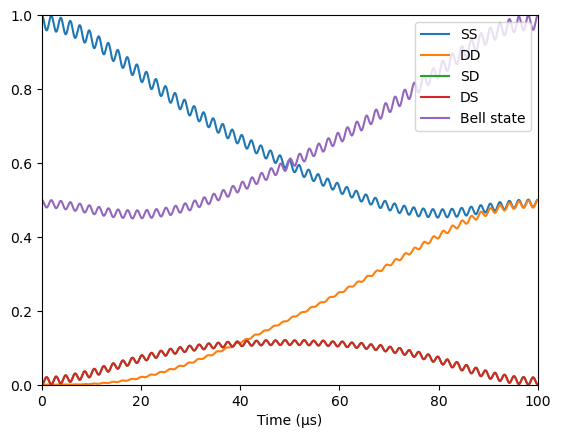

  5.594631 seconds (13.97 M allocations: 880.494 MiB, 7.58% gc time, 97.63% compilation time)
Bell-state fidelity: 0.99956612010231
Electronic-Motional entanglement entropy: 0.005708204423706869


/home/aelabd/.julia/conda/3/x86_64/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/aelabd/.julia/conda/3/x86_64/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


In [5]:
h = hamiltonian(chamber, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf);
@time tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ψ0, h);
plot_populations(chamber, tout, sol)

ρ_final = dm(sol[end])
ρ_final_electronic = ptrace(ρ_final, 3)
bs_fid = fidelity(ρ_final_electronic, BELL_STATE)
ee = entropy_vn(ρ_final_electronic)
print("Bell-state fidelity: ", real(bs_fid), "\n")
print("Electronic-Motional entanglement entropy: ", real(ee), "\n")

# 1. Compute intensity variance

$I \propto \Omega^2 \Longrightarrow I = \kappa \Omega^2$. This gives the result: $\sigma_I^2 = \kappa^2 \bigg( 2\sigma_{\Omega}^4 + 4\bar{\Omega}^2 \sigma_{\Omega}^2 \bigg)$. (See **single_qubit_rotations/Intensity Uncertainty.pdf** for the derivation.) 

We estimate $\kappa$ as $\kappa \approx I_{\text{opt}}/\Omega_{\text{opt}}^2$. 

In [6]:
function find_rabi_freq(tout, sol, timescale)
    SS = ionprojector(chamber, "S", "S")
    prob_ZZ_plus = expect(SS, sol);
    prob_ZZ_plus_1up = broadcast(abs, prob_ZZ_plus[2:end]);
    max_prob_idx = findall(broadcast(abs, prob_ZZ_plus_1up.-maximum(prob_ZZ_plus_1up)) .< 1e-8)[1];
    period = tout[max_prob_idx+1]-tout[1];
    period *= timescale
    freq = 1/period
    return freq
end

find_rabi_freq (generic function with 1 method)

In [7]:
Ω_opt = find_rabi_freq(tout, sol, TIMESCALE)
κ = INTENSITY/(Ω_opt^2)

σΩ = 0.2Ω_opt
σI = κ*sqrt(2*(σΩ^4) + 4*(σΩ^2)*Ω_opt^2 )
σI/INTENSITY

0.4039801975344831

In [8]:
1/Ω_opt

1.0e-7

## 2. Vary intensity

Recording fidelity and electronic-motional entanglement entropy

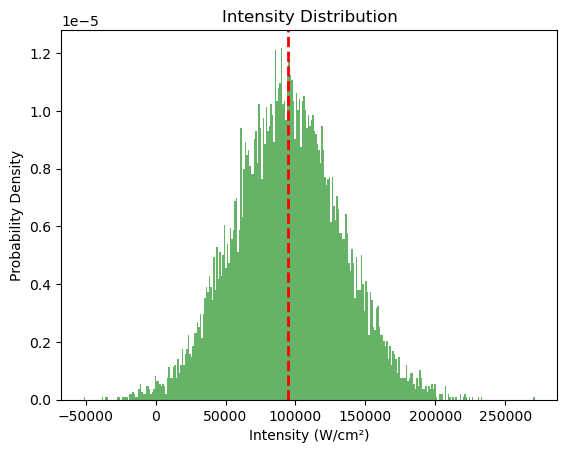

In [9]:
N_I = Normal(INTENSITY, σI)
I_dist = rand(N_I, N_SAMPLES)

fig = plt.figure()
plt.hist(I_dist, bins=300, density=true, alpha=0.6, color="g")
plt.axvline(x=INTENSITY, color="r", linestyle="--", linewidth=2)
plt.title("Intensity Distribution")
plt.xlabel("Intensity (W/cm²)")
plt.ylabel("Probability Density")
plt.display(fig)

In [61]:
fidelities_I = zeros(length(I_dist))
entanglement_entropies_I = zeros(length(I_dist));

for i in 1:N_SAMPLES
    if i%Int(1e2)==0
        print("\n", i)
        flush(stdout)
    end

    I = I_dist[i]
    if I < 0
        fidelities_I[i] = NaN
        entanglement_entropies_I[i] = NaN
    else
        intensity!(chamber.lasers[1], I)
        intensity!(chamber.lasers[2], I)

        h = hamiltonian(chamber, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf);
        tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ψ0, h);
        ρ_final = dm(sol[end])
        ρ_final_electronic = ptrace(ρ_final, 3)
        fid_i = fidelity(ρ_final_electronic, BELL_STATE)
        S_i = entropy_vn(ρ_final_electronic)
        
        fidelities_I[i] = real(fid_i)
        entanglement_entropies_I[i] = S_i

    end
end



100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000

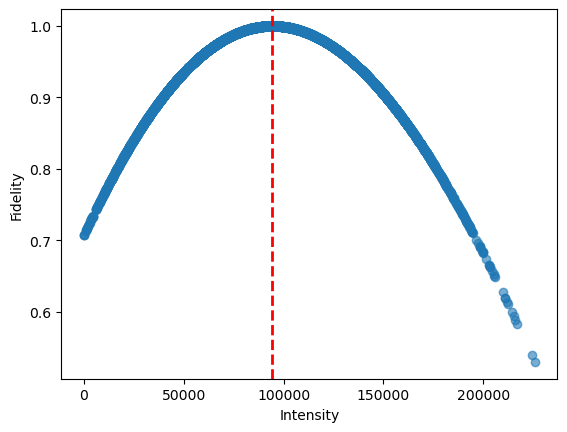

In [62]:
fig = plt.figure()
plt.plot(I_dist, fidelities_I, "o", alpha=0.6)
plt.axvline(x=INTENSITY, color="r", linestyle="--", linewidth=2)
plt.xlabel("Intensity")
plt.ylabel("Fidelity")
plt.display(fig)

In [63]:
fidelities_I = fidelities_I[.~isnan.(fidelities_I)]
print("\nlength(fidelities_I) = ", length(fidelities_I))

entanglement_entropies_I = entanglement_entropies_I[.~isnan.(entanglement_entropies_I)]
print("\nlength(entanglement_entropies_I) = ", length(entanglement_entropies_I))


length(fidelities_I) = 9938
length(entanglement_entropies_I) = 9938

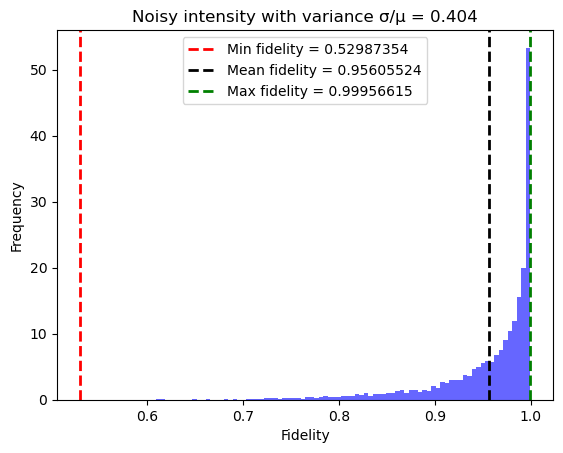

In [65]:
fig = plt.figure()
plt.hist(fidelities_I, bins=100, density=true, alpha=0.6, color="b")
plt.axvline(minimum(fidelities_I), color="r", linestyle="--", linewidth=2, label="Min fidelity = $(round(minimum(fidelities_I); digits=8))")
plt.axvline(mean(fidelities_I), color="k", linestyle="--", linewidth=2, label="Mean fidelity = $(round(mean(fidelities_I); digits=8))")
plt.axvline(maximum(fidelities_I), color="g", linestyle="--", linewidth=2, label="Max fidelity = $(round(maximum(fidelities_I); digits=8))")
plt.xlabel("Fidelity")
plt.ylabel("Frequency")
plt.title("Noisy intensity with variance σ/μ = $(round(σI/INTENSITY; digits=3))")
plt.legend()
plt.display(fig)

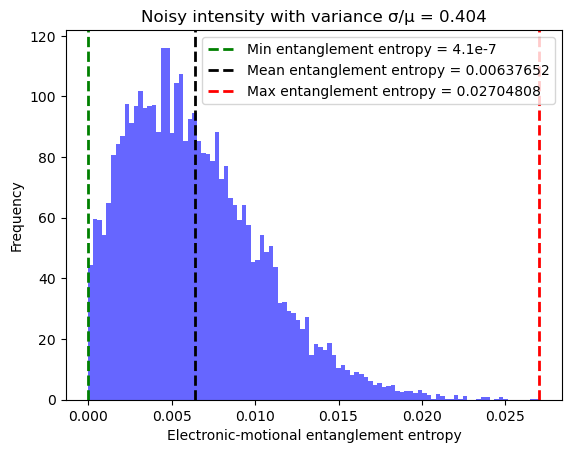

In [66]:
fig = plt.figure()
plt.hist(entanglement_entropies_I, bins=100, density=true, alpha=0.6, color="b")
plt.axvline(minimum(entanglement_entropies_I), color="g", linestyle="--", linewidth=2, label="Min entanglement entropy = $(round(minimum(entanglement_entropies_I); digits=8))")
plt.axvline(mean(entanglement_entropies_I), color="k", linestyle="--", linewidth=2, label="Mean entanglement entropy = $(round(mean(entanglement_entropies_I); digits=8))")
plt.axvline(maximum(entanglement_entropies_I), color="r", linestyle="--", linewidth=2, label="Max entanglement entropy = $(round(maximum(entanglement_entropies_I); digits=8))")
plt.xlabel("Electronic-motional entanglement entropy")
plt.ylabel("Frequency")
plt.title("Noisy intensity with variance σ/μ = $(round(σI/INTENSITY; digits=3))")
plt.legend()
plt.display(fig)

# 3. Vary center-line frequency

In [10]:
δλ_MAX = 1e-15
C0 = 2.99792458e8
FREQUENCY_CL = C0/WAVELENGTH_CL
σf = 2e3

2000.0

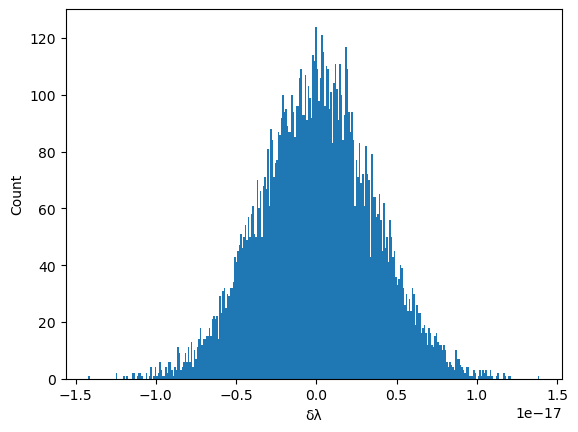

In [11]:
N_f = Normal(FREQUENCY_CL, σf)
f_dist = rand(N_f, N_SAMPLES)

λ_dist = C0./f_dist
δλ_dist = WAVELENGTH_CL .- λ_dist;
fig = plt.figure()
plt.hist(δλ_dist, bins=300)
plt.xlabel("δλ")
plt.ylabel("Count")
plt.display(fig)

In [12]:
sum(broadcast(abs, δλ_dist) .> δλ_MAX)

0

In [70]:
intensity!(chamber.lasers[1], INTENSITY)
intensity!(chamber.lasers[2], INTENSITY)

fidelities_frequency = zeros(length(f_dist))
entanglement_entropies_frequency = zeros(length(f_dist))

for i in 1:N_SAMPLES
    if i%Int(1e2)==0
        print("\n", i)
        flush(stdout)
    end

    f = f_dist[i]
    λ = C0/f

    wavelength!(chamber.lasers[1], λ)
    wavelength!(chamber.lasers[1], λ)

    
    h = hamiltonian(chamber, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf);
    tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ψ0, h);
    ρ_final = dm(sol[end])
    ρ_final_electronic = ptrace(ρ_final, 3)
    fid_i = fidelity(ρ_final_electronic, BELL_STATE)
    S_i = entropy_vn(ρ_final_electronic)
        
    fidelities_frequency[i] = real(fid_i)
    entanglement_entropies_frequency[i] = S_i
end


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000

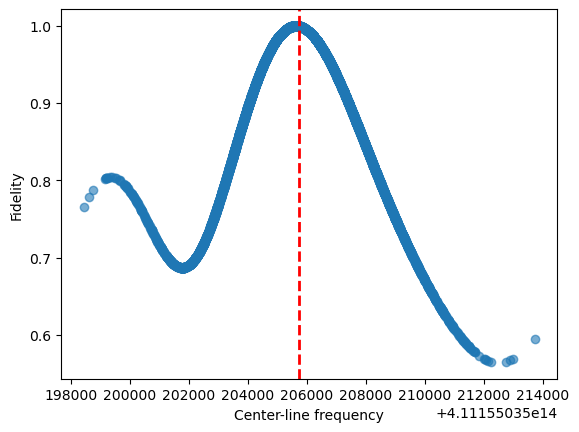

sys:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.


In [72]:
fig = plt.figure()
plt.plot(f_dist, fidelities_frequency, "o", alpha=0.6)
plt.axvline(x=FREQUENCY_CL, color="r", linestyle="--", linewidth=2)
plt.xlabel("Center-line frequency")
plt.ylabel("Fidelity")
plt.display(fig)

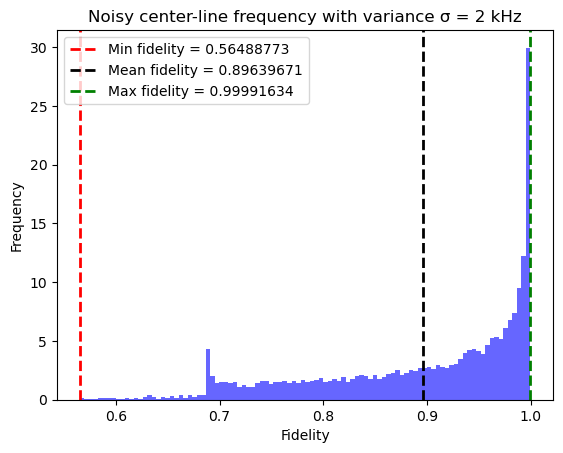

In [73]:
fig = plt.figure()
plt.hist(fidelities_frequency, bins=100, density=true, alpha=0.6, color="b")
plt.axvline(minimum(fidelities_frequency), color="r", linestyle="--", linewidth=2, label="Min fidelity = $(round(minimum(fidelities_frequency); digits=8))")
plt.axvline(mean(fidelities_frequency), color="k", linestyle="--", linewidth=2, label="Mean fidelity = $(round(mean(fidelities_frequency); digits=8))")
plt.axvline(maximum(fidelities_frequency), color="g", linestyle="--", linewidth=2, label="Max fidelity = $(round(maximum(fidelities_frequency); digits=8))")
plt.xlabel("Fidelity")
plt.ylabel("Frequency")
plt.title("Noisy center-line frequency with variance σ = 2 kHz")
plt.legend()
plt.display(fig)

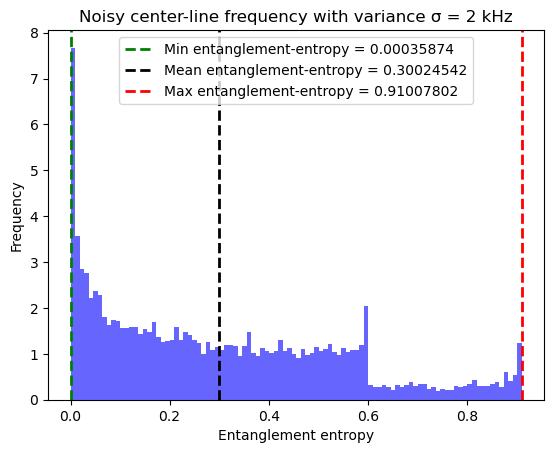

In [74]:
fig = plt.figure()
plt.hist(entanglement_entropies_frequency, bins=100, density=true, alpha=0.6, color="b")
plt.axvline(minimum(entanglement_entropies_frequency), color="g", linestyle="--", linewidth=2, label="Min entanglement-entropy = $(round(minimum(entanglement_entropies_frequency); digits=8))")
plt.axvline(mean(entanglement_entropies_frequency), color="k", linestyle="--", linewidth=2, label="Mean entanglement-entropy = $(round(mean(entanglement_entropies_frequency); digits=8))")
plt.axvline(maximum(entanglement_entropies_frequency), color="r", linestyle="--", linewidth=2, label="Max entanglement-entropy = $(round(maximum(entanglement_entropies_frequency); digits=8))")
plt.xlabel("Entanglement entropy")
plt.ylabel("Frequency")
plt.title("Noisy center-line frequency with variance σ = 2 kHz")
plt.legend()
plt.display(fig)

## 4. Vary trap-frequency

TODO: Include diagram from Sara meeting

Trap-frequency fluctuation $\Longleftrightarrow$ all reds spread (positive change) or squeeze (negative change)

In [13]:
σΔ = 2e3
σν = σΔ

2000.0

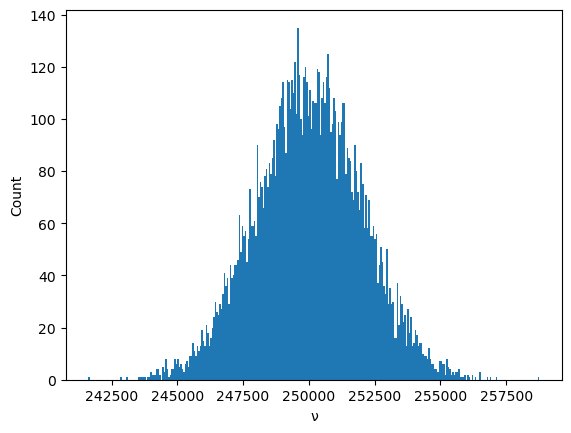

In [14]:
N_ν  = Normal(TRAP_FREQUENCY, σν)
ν_dist = rand(N_ν, N_SAMPLES)

fig = plt.figure()
plt.hist(ν_dist, bins=300)
plt.xlabel("ν")
plt.ylabel("Count")
plt.display(fig)

In [83]:
fidelities_trap_frequency = zeros(length(ν_dist))
entanglement_entropies_trap_frequency = zeros(length(ν_dist))

for i in 1:N_SAMPLES
    if i%Int(1e3)==0
        print("\n", i)
        flush(stdout)
    end

    if i>Int(9e3)
        if i%100==0
            print("\n", i)
            flush(stdout)
        end
    end


    try
        # actual trap-frequency is ν
        ν = ν_dist[i]
        chamber = construct_MS_chamber(
            ν,
            INTENSITY,
            WAVELENGTH_CL,
            DETUNING,
            AC_CORRECTION,
            B_STRENGTH
        )

        # But detuning is based on target trap-frequency
        chamber.lasers[1].Δ = TRAP_FREQUENCY + DETUNING - AC_CORRECTION
        chamber.lasers[2].Δ = -(TRAP_FREQUENCY + DETUNING - AC_CORRECTION)
        h = hamiltonian(chamber, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf);
        tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ψ0, h);
        ρ_final = dm(sol[end])
        ρ_final_electronic = ptrace(ρ_final, 3)
        fid_i = fidelity(ρ_final_electronic, BELL_STATE)
        S_i = entropy_vn(ρ_final_electronic)

        #@assert imag(fid) < 1e-8
        fidelities_trap_frequency[i] = real(fid_i)
        entanglement_entropies_trap_frequency[i] = S_i
    catch
        fidelities_trap_frequency[i] = NaN
        entanglement_entropies_trap_frequency[i] = NaN
    end
end


1000
2000
3000
4000
5000
6000
7000
8000
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10000

In [15]:
fidelities_trap_frequency = fidelities_trap_frequency[.~isnan.(fidelities_trap_frequency)]
print("\nlength(fidelities_trap_frequency) = ", length(fidelities_trap_frequency))

entanglement_entropies_trap_frequency = entanglement_entropies_trap_frequency[.~isnan.(entanglement_entropies_trap_frequency)]
print("\nlength(entanglement_entropies_trap_frequency) = ", length(entanglement_entropies_trap_frequency))

UndefVarError: UndefVarError: `fidelities_trap_frequency` not defined

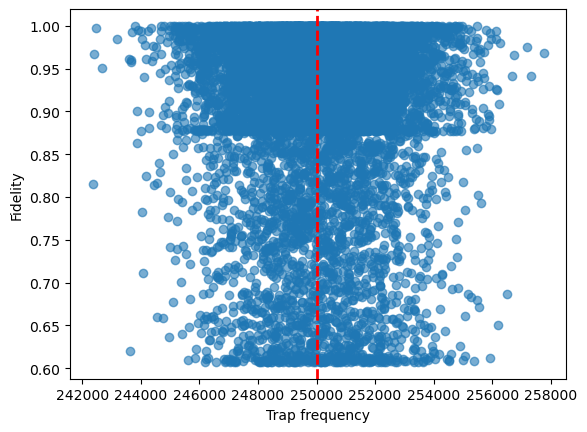

In [88]:
fig = plt.figure()
plt.plot(ν_dist[3:end], fidelities_trap_frequency, "o", alpha=0.6)
plt.axvline(x=TRAP_FREQUENCY, color="r", linestyle="--", linewidth=2)
plt.xlabel("Trap frequency")
plt.ylabel("Fidelity")
plt.display(fig)

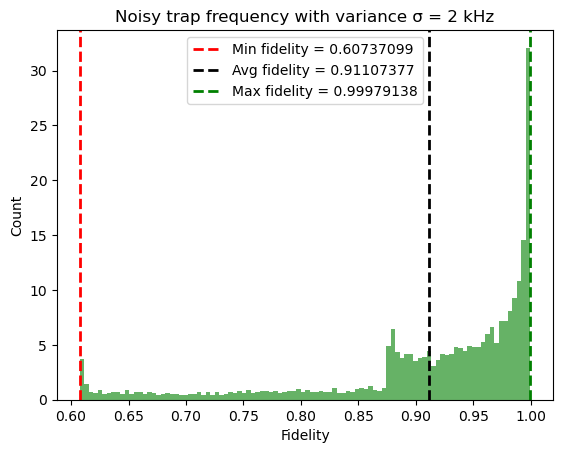

In [89]:
fig = plt.figure()
plt.hist(fidelities_trap_frequency, bins=100, density=true, alpha=0.6, color="g")
plt.axvline(minimum(fidelities_trap_frequency), color="r", linestyle="--", linewidth=2, label="Min fidelity = $(round(minimum(fidelities_trap_frequency); digits=8))")
plt.axvline(mean(fidelities_trap_frequency), color="k", linestyle="--", linewidth=2, label="Avg fidelity = $(round(mean(fidelities_trap_frequency); digits=8))")
plt.axvline(maximum(fidelities_trap_frequency), color="g", linestyle="--", linewidth=2, label="Max fidelity = $(round(maximum(fidelities_trap_frequency); digits=8))")
plt.xlabel("Fidelity")
plt.ylabel("Count")
plt.title("Noisy trap frequency with variance σ = 2 kHz")
plt.legend()
plt.display(fig)

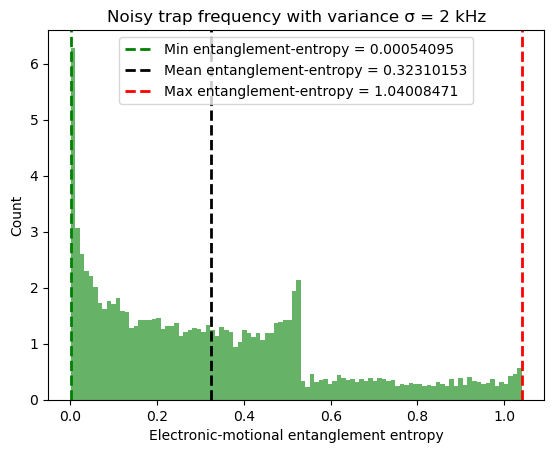

In [90]:
fig = plt.figure()
plt.hist(entanglement_entropies_trap_frequency, bins=100, density=true, alpha=0.6, color="g")
plt.axvline(minimum(entanglement_entropies_trap_frequency), color="g", linestyle="--", linewidth=2, label="Min entanglement-entropy = $(round(minimum(entanglement_entropies_trap_frequency); digits=8))")
plt.axvline(mean(entanglement_entropies_trap_frequency), color="k", linestyle="--", linewidth=2, label="Mean entanglement-entropy = $(round(mean(entanglement_entropies_trap_frequency); digits=8))")
plt.axvline(maximum(entanglement_entropies_trap_frequency), color="r", linestyle="--", linewidth=2, label="Max entanglement-entropy = $(round(maximum(entanglement_entropies_trap_frequency); digits=8))")
plt.xlabel("Electronic-motional entanglement entropy")
plt.ylabel("Count")
plt.title("Noisy trap frequency with variance σ = 2 kHz")
plt.legend()
plt.display(fig)

# 5. Vary all parameters at once

In [16]:
fidelities = zeros(N_SAMPLES)
entanglement_entropies = zeros(N_SAMPLES)

for i in 1:N_SAMPLES
    if i%Int(1e2)==0
        print("\n", i)
        flush(stdout)
    end

    I = rand(N_I)[1]
    if I<0
        fidelities[i] = NaN
        entanglement_entropies[i] = NaN
        continue
    end

    f = rand(N_f)[1]
    λ = C0/f

    ν = rand(N_ν)[1]
    
    try
        # actual trap-frequency is ν
        chamber = construct_MS_chamber(
            ν,
            I,
            λ,
            DETUNING,
            AC_CORRECTION,
            B_STRENGTH
        )

        # But detuning is based on target trap-frequency
        chamber.lasers[1].Δ = TRAP_FREQUENCY + DETUNING - AC_CORRECTION
        chamber.lasers[2].Δ = -(TRAP_FREQUENCY + DETUNING - AC_CORRECTION)
        h = hamiltonian(chamber, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf)
        tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ψ0, h)
        ρ_final = dm(sol[end])
        ρ_final_electronic = ptrace(ρ_final, 3)
        fid_i = fidelity(ρ_final_electronic, BELL_STATE)
        S_i = entropy_vn(ρ_final_electronic)

        #@assert imag(fid) < 1e-8
        fidelities[i] = real(fid_i)
        entanglement_entropies[i] = S_i
    catch
        fidelities[i] = NaN
        entanglement_entropies[i] = NaN
    end
end


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000

In [17]:
fidelities = fidelities[.~isnan.(fidelities)]
print("\nlength(fidelities) = ", length(fidelities))

entanglement_entropies = entanglement_entropies[.~isnan.(entanglement_entropies)]
print("\nlength(entanglement_entropies) = ", length(entanglement_entropies))


length(fidelities) = 9938
length(entanglement_entropies) = 9938

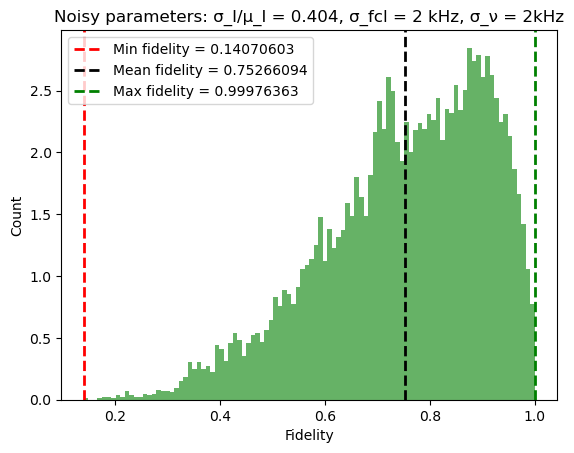

In [23]:
fig = plt.figure()
plt.hist(fidelities, bins=100, density=true, alpha=0.6, color="g")
plt.axvline(minimum(fidelities), color="r", linestyle="--", linewidth=2, label="Min fidelity = $(round(minimum(fidelities); digits=8))")
plt.axvline(mean(fidelities), color="k", linestyle="--", linewidth=2, label="Mean fidelity = $(round(mean(fidelities); digits=8))")
plt.axvline(maximum(fidelities), color="g", linestyle="--", linewidth=2, label="Max fidelity = $(round(maximum(fidelities); digits=8))")
plt.xlabel("Fidelity")
plt.ylabel("Count")
plt.title("Noisy parameters: σ_I/μ_I = 0.404, σ_fcl = 2 kHz, σ_ν = 2kHz")
plt.legend()
plt.display(fig)

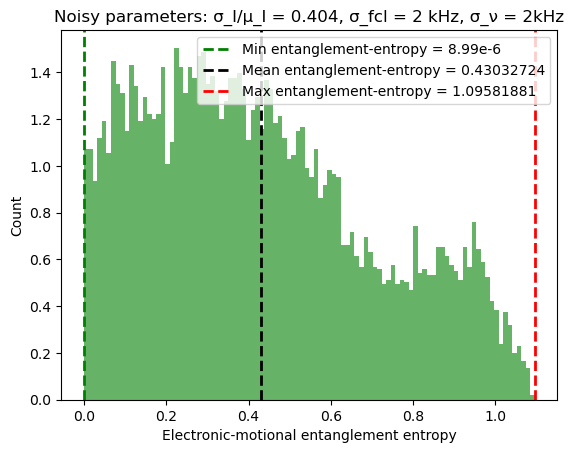

In [22]:
fig = plt.figure()
plt.hist(entanglement_entropies, bins=100, density=true, alpha=0.6, color="g")
plt.axvline(minimum(entanglement_entropies), color="g", linestyle="--", linewidth=2, label="Min entanglement-entropy = $(round(minimum(entanglement_entropies); digits=8))")
plt.axvline(mean(entanglement_entropies), color="k", linestyle="--", linewidth=2, label="Mean entanglement-entropy = $(round(mean(entanglement_entropies); digits=8))")
plt.axvline(maximum(entanglement_entropies), color="r", linestyle="--", linewidth=2, label="Max entanglement-entropy = $(round(maximum(entanglement_entropies); digits=8))")
plt.xlabel("Electronic-motional entanglement entropy")
plt.ylabel("Count")
plt.title("Noisy parameters: σ_I/μ_I = 0.404, σ_fcl = 2 kHz, σ_ν = 2kHz")
plt.legend()
plt.display(fig)